In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import random
import cPickle as pickle
%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

np.random.seed(1337)
import keras

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Plotting settings ###
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2.5
plt.rcParams['xtick.labelsize']= 24
plt.rcParams['ytick.labelsize']= 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 7
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.edgecolor'] = 'black'

def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
    if layers >= 2:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, nb_epoch=nb_epoch, verbose=1)
    return model

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x],data[y])
    return r_value**2

def eval_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[obs_col],scaler.inverse_transform(predictions))
    return r_value**2

### Load all EGFP data. Rename total reads and RL columns to represent each data set in the merged dataframe.
e1 & e2 = unmodified RNA EGFP........ep1 & ep2 = pseudouridine EGFP........emp1 & emp2 = m1pseudouridine

In [44]:
e1 = pd.read_pickle('../../data/egfp_unmod_1.pkl')
e1['e1_rl'] = e1['rl']
e1['e1_total'] = e1['total_reads']
e1['utr'] = e1['utr'].str[:50]

e2 = pd.read_pickle('../../data/egfp_unmod_2.pkl')
e2['e2_rl'] = e2['rl']
e2['e2_total'] = e2['total']
e2['utr'] = e2['utr'].str[:50]

ep1 = pd.read_pickle('../../data/egfp_pseudo_1.pkl')
ep1['ep1_rl'] = ep1['rl']
ep1['ep1_total'] = ep1['total']
ep1['utr'] = ep1['utr'].str[:50]

ep2 = pd.read_pickle('../../data/egfp_pseudo_2.pkl')
ep2['ep2_rl'] = ep2['rl']
ep2['ep2_total'] = ep2['total']
ep2['utr'] = ep2['utr'].str[:50]

emp1 = pd.read_pickle('../../data/egfp_m1pseudo_1.pkl')
emp1['emp1_rl'] = emp1['rl']
emp1['emp1_total'] = emp1['total']
emp1['utr'] = emp1['utr'].str[:50]
                      
emp2 = pd.read_pickle('../../data/egfp_m1pseudo_2.pkl')
emp2['emp2_rl'] = emp2['rl']
emp2['emp2_total'] = emp2['total']
emp2['utr'] = emp2['utr'].str[:50]

#### Merge data into a single dataframe. Take the 'inner' merge to select UTRs that are found in all samples.

In [45]:
df = pd.merge(e1, e2, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total']]

df = pd.merge(df, ep1, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total', 'ep1_total', 'ep1_rl']]
print len(df)
df = pd.merge(df, emp1, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total', 'ep1_total', 'ep1_rl', 'emp1_total', 'emp1_rl']]
print len(df)
df = pd.merge(df, ep2, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total', 'ep1_total', 'ep1_rl', 'emp1_total', 'emp1_rl',
        'ep2_total', 'ep2_rl']]
print len(df)
df = pd.merge(df, emp2, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total', 'ep1_total', 'ep1_rl', 'emp1_total', 'emp1_rl',
        'ep2_total', 'ep2_rl', 'emp2_total', 'emp2_rl']]
print len(df)

df.dropna(how='any', inplace=True)
print len(df)

e1 = None
e2 = None
h8 = None
h10 = None
h8m = None
h10m = None

320497
320497
318921
318468
318115


#### Enrich for UTRs that have high read counts across each data set. Sort by reads, remove 10k of lowest UTRs, move on to the next set, sort, cut 10k, etc.
Note that the train / test split is the same between all data sets.

In [46]:
df.sort_values('e2_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:305000]
df.sort_values('e1_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:300000]
df.sort_values('ep1_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:290000]
df.sort_values('emp1_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]
df.sort_values('emp2_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:270000]
df.sort_values('ep2_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:260000]

#### Typically, we do a train / test split based on total number of reads for a sample. Now we have multiple samples, splitting based on total reads for one say, egfp #1, may bias the model resulting in poorer performance on the other samples. In an attempt to get around that, we train-test split and model for each sample and then average the performances across all 6 models.
Iterate through samples by change sort_values below. Do this for each sample and save the performance dictionary.

In [47]:
df.sort_values('e1_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

# Train / test split --- test set is the 20k sequences with the highest number of reads
e_test = df[:20000]
e_test.reset_index(inplace=True, drop=True)
e_train = df[20000:]
e_train.reset_index(inplace=True, drop=True)

# One-hot encode UTR sequences
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale ribosome loads
e_train.loc[:,'e1_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'e1_rl'].reshape(-1,1))
e_train.loc[:,'e2_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'e2_rl'].reshape(-1,1))
e_train.loc[:,'ep1_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'ep1_rl'].reshape(-1,1))
e_train.loc[:,'ep2_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'ep2_rl'].reshape(-1,1))
e_train.loc[:,'emp1_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'emp1_rl'].reshape(-1,1))
e_train.loc[:,'emp2_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'emp2_rl'].reshape(-1,1))

# Select only useful columns
e_train = e_train[['utr', 'e1_scaled_rl', 'e1_total', 'e2_scaled_rl', 'e2_total', 'ep1_scaled_rl', 'ep1_total',
                  'emp1_scaled_rl', 'emp1_total', 'ep2_scaled_rl', 'ep2_total', 'emp2_scaled_rl', 'emp2_total']]

#### Train models

In [48]:
# Dictionaries to store models and model performance on all data
model_dict = {}
performance_dict = {}

# Train & test on all samples
for sample in ['e1', 'e2', 'ep1', 'ep2', 'emp1', 'emp2']:
    m_name = sample + '_model'
    
    # Train
    model_dict[m_name] = train_model(seq_e_train, e_train[sample + '_scaled_rl'], nb_epoch=3,border_mode='same',
                       inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                       dropout2=0,dropout3=0.2)
    
    # Save model
    model = model_dict[m_name]
    
    # Evaluate on self and the other data sets
    e1 = eval_data(e_test, model, seq_e_test, 'e1_rl')
    e2 = eval_data(e_test, model, seq_e_test, 'e2_rl')
    ep1 = eval_data(e_test, model, seq_e_test, 'ep1_rl')
    ep2 = eval_data(e_test, model, seq_e_test, 'ep2_rl')
    emp1 = eval_data(e_test, model, seq_e_test, 'emp1_rl')
    emp2 = eval_data(e_test, model, seq_e_test, 'emp2_rl')
    
    # Save model performance
    performance_dict[m_name] = (e1, e2, ep1, ep2, emp1, emp2)
    print m_name, performance_dict[m_name]
    print

Epoch 1/3
240000/240000 [==============================] - 59s - loss: 0.2281    
Epoch 2/3
240000/240000 [==============================] - 59s - loss: 0.1307    
Epoch 3/3
240000/240000 [==============================] - 59s - loss: 0.1185    
e1_model (0.93503423517568884, 0.87653726230325768, 0.71397933362988242, 0.76100760981312088, 0.69952261553497475, 0.7747782315906393)

Epoch 1/3
240000/240000 [==============================] - 59s - loss: 0.3323    
Epoch 2/3
240000/240000 [==============================] - 59s - loss: 0.2117    
Epoch 3/3
240000/240000 [==============================] - 59s - loss: 0.1947    
e2_model (0.89981547323098976, 0.89470861126621803, 0.70483378537896624, 0.77456589254386576, 0.6821694635277652, 0.78303647632264728)

Epoch 1/3
240000/240000 [==============================] - 59s - loss: 0.4986    
Epoch 2/3
240000/240000 [==============================] - 59s - loss: 0.4021    
Epoch 3/3
240000/240000 [==============================] - 59s - loss: 0

#### Save models and model performance on test sets

In [49]:
for k, v in model_dict.iteritems():
    keras.models.save_model(v, k + '.h5')
    
with open('./saved_data/e1_model_performance.dict', 'wb') as f:
    pickle.dump(performance_dict, f)

#### Load performance dictionaries and average

In [57]:
avg_perf = np.zeros((6,6))
for sample in ['e1', 'e2', 'ep1', 'ep2', 'emp1', 'emp2']:
    d = pickle.load(open('./saved_data/' + sample + '_model_performance.dict', 'rb'))
    a = np.array((d['e1_model'], d['e2_model'], d['ep1_model'], d['ep2_model'], d['emp1_model'], d['emp2_model']))
    avg_perf = avg_perf + a
    
avg_perf = avg_perf / 6
avg_perf = avg_perf.T

## Plot heatmap of model performance

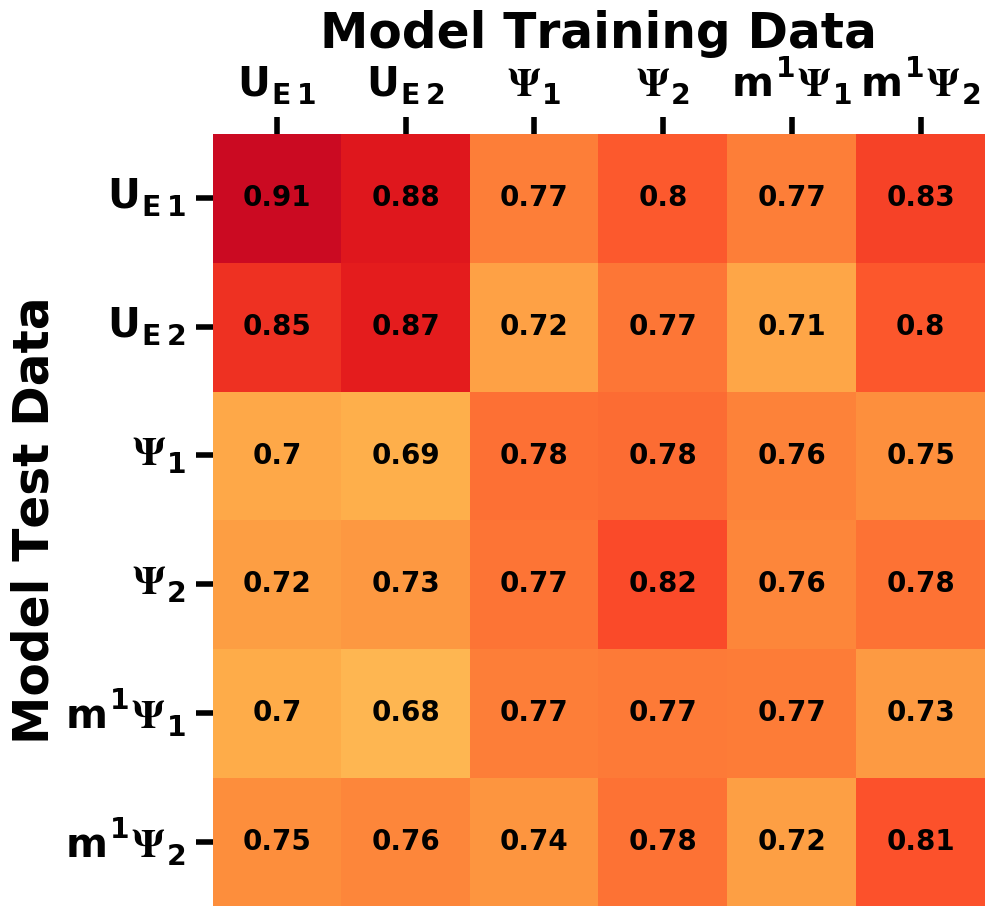

In [60]:
ax =sns.heatmap(avg_perf, annot=True, cmap='YlOrRd', vmin=0.5, vmax=1, annot_kws={'size':'20', 'color':'black'}, cbar=False, square=True)
f = ax.get_figure()
f.set_size_inches((9.5,9.5))
ax.set_xticklabels([r'U${_E}{_1}$', r'U${_E}{_2}$', r'$\Psi{_1}$', r'$\Psi{_2}$', r'$m^1\Psi{_1}$',
                    r'$m^1\Psi{_2}$'], fontsize=29, fontdict={'family':'arial'})
ax.set_yticklabels([r'$m^1\Psi{_2}$', r'$m^1\Psi{_1}$', r'$\Psi{_2}$', r'$\Psi{_1}$', r'U${_E}{_2}$',
                    r'U${_E}{_1}$'], fontsize=29, fontdict={'family':'arial'}, rotation=0)
ax.set_xlabel('Model Training Data', size = 35, fontdict={'family':'arial'})
ax.set_ylabel('Model Test Data', size=35, fontdict={'family':'arial'})
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top');

In [ ]:
f.savefig('/data/5utr/modeling/combined_data/chemistry/images/egfp_chemistries_only_avg_perf_6models_tested_heatmap_201709256.eps', format=('eps'))